<h1 style='text-align: center;'>Survivor:</h1>
<h2 style='text-align: center;'>Exploring Contestant Trends Through Data</h2>

This projects aims to look at the long-running CBS show Survivor over the years, and determine what demographics of contestants are more likely to win.

We will also be looking to see if there are any trends where certain demographics have lower chances of winning.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from scraper import find_closest_match
# Data pulled in/ saved to csv from 2/27/2025

c:\Users\camil\OneDrive\Documents\Projects\Capstone\scraper.py:222: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  contestant_table.replace({'Survivor: Borneo': 1,


contestants.csv already exists.
stats.csv already exists.
idols.csv already exists.
advantages.csv already exists.
immunities.csv already exists.


### Importing Data

In [2]:
contestants = pd.read_csv('contestants.csv')
stats = pd.read_csv('stats.csv')
idols = pd.read_csv('idols.csv')
advantages = pd.read_csv('advantages.csv')
immunities = pd.read_csv('immunities.csv')

In [3]:
contestants.tail(3)

,Season,Name,Age,Hometown,Profession,Finish,Ethnicity,Gender,Lgbt,Has Disability,State,Country
872,48,Chrissy Sarnowsky,55,"Chicago, IL",Fire Lieutenant,0,White,F,False,False,IL,USA
873,48,Star Toomey,28,"Augusta, GA",Sales Expert,0,African-American,F,True,False,GA,USA
874,48,Mary Zheng,31,"Philadelphia, PA",Substance Abuse Counselor,0,Asian-American,F,False,False,PA,USA


### Cleaning Data

After loading the datasets in, it's time to clean the data. 
I want to take the tables for advantages, idols, and individual immunity challenges, and add them to the stats table.

To do this, I create a function that cleans these tables. This function drops unnecessary and duplicate columns, strips column names, replaces and fills values as needed, and changes the dtypes of columns to match the values. It then merges the tables together on the Contestant and Season columns, using outer join for the advantages, idols, and immunities tables so to not lose any data, and then using a left join on the stats table, filtering out any contestants not included elsewhere in the data (ie, from seasons of the Australian version of the show)

In [4]:
def clean_and_merge(advantages:pd.DataFrame, idols:pd.DataFrame, immunities:pd.DataFrame, stats:pd.DataFrame) -> pd.DataFrame:
    """
    Cleans tables for advantages, idols and immunities, then merges them to the stats table.

    Args:
        advantages(DataFrame): pd.DataFrame containing data on contestants who have found advantages
        idols(DataFrame): pd.DataFrame containing data on top contestants who have found immunity idols
        immunities(DataFrame): pd.DataFrame containing data on contestants who have won individual immunity challenges
        stats(DataFrame): pd.DataFrame consisting of data on contestants overall performance in the game
    Returns:
        DataFrame: Merges advantages, idols, and immunities Dataframes into the stats Dataframe
    """
    try:
        # drop columns
        advantages = advantages.drop(columns=['Rank', 'Contestant', 'VV', 'VFB', 'Tie broken?'])
        idols = idols.drop(columns=['Rank', 'Contestant'])
        immunities = immunities.drop(columns=['Rank', 'Contestant'])
        # change column names 
        advantages.columns = advantages.columns.str.strip().str.replace('.1', '')
        idols.columns = idols.columns.str.strip().str.replace('.1', '')
        immunities.columns = immunities.columns.str.strip().str.replace('.1', '')
        # strip and replace values (Season column of S, idols table of special characters (*,†/+,#))
        advantages['Season'] = advantages['Season'].str.replace('S', '')
        advantages['Season'] = advantages['Season'].replace({
            'Game Changers': 34,
            'David vs. Goliath': 37,
            'Winners at War': 40,
            'Cambodia': 31,
            'Island of the Idols': 39,
            'HvHvH': 35,
            'Worlds Apart': 30,
            'Kaoh Rong': 32,
            'Ghost Island': 36,
            'urvivor 42': 42,
            'Edge of Extinction': 38,
            'MvGX': 33   
        })
        advantages['Season'] = advantages['Season'].astype(int) 

        idols['Season'] = idols['Season'].str.replace('S', '') 
        idols['Contestant'] = idols['Contestant'].str.rstrip('*').str.rstrip('#').str.rstrip('+')
        idols['IH'] = idols['IH'].str.rstrip('*').str.rstrip('#').str.rstrip('+')
        idols['IP'] = idols['IP'].str.rstrip('*').str.rstrip('#').str.rstrip('+')
        idols['VV'] = idols['VV'].str.rstrip('†').str.rstrip('#')
        idols = idols.drop(idols[idols['Season'] == '--'].index)
        idols['IH'] = idols['IH'].astype(int)
        idols['IP'] = idols['IP'].astype(int)
        idols['VV'] = idols['VV'].astype(int)
        idols['Season'] = idols['Season'].astype(int)

        immunities['Season'] = immunities['Season'].str.split(':').str[0]
        immunities['Season'] = immunities['Season'].str.strip('Survivor').str.strip('S')
        immunities['Season'] = immunities['Season'].astype(int)
        
        if 'Notes' in stats.columns:
            print('Tables have already been merged')
        
        else:
            # merge advantages/idols/immunities together (before merging them to stats?)
            merged_idols = pd.merge(idols, advantages, on=['Contestant', 'Season'], how='outer')
            merged_all = pd.merge(merged_idols, immunities, on=['Contestant', 'Season'], how='outer')
            stats = pd.merge(stats, merged_all, on=['Contestant', 'Season'], how='left')
        # reorder columns to be more readable
        stats = stats[['Season', 'Contestant', 'SurvSc', 'SurvAv', 'ChW', 'ChA', 'ChW%',
                                'SO', 'VFB', 'VAP','TotV','TCA','TC%','wTCR','JVF', 'TotJ', 
                                'JV%', 'IF', 'IH', 'IP', 'VV', 'ICW', 'ICA', 'AF', 'AP', 'Notes']]
        
        stats['VAP'] = stats['VAP'].astype(str).str.rstrip('*')
        stats['TotV'] = stats['TotV'].astype(str).str.rstrip('*')
        stats['TCA'] = stats['TCA'].astype(str).str.rstrip('*')
        stats['TC%'] = stats['TC%'].astype(str).str.rstrip('*')
        stats['wTCR'] = stats['wTCR'].astype(str).str.rstrip('*')
        
        # drop rows where SurvSc is null (Season 48 - no values for stats yet)
        stats = stats.dropna(subset='SurvSc')
        # fill null values (notes with NA, everything else with 0)
        stats['Notes'] = stats['Notes'].fillna('NA')
        stats = stats.fillna(0)
        stats = stats.replace('-', '0')
        # to float- survsc, survav, chw, cha, chw%, tc%, wtcr, jv%
        # to int- so, vfb, vap, totv, tca, jvf, totj
        stats = stats.astype({
        'SurvSc': 'float64', 'SurvAv': 'float64', 'ChW': 'float64', 'ChA': 'float64',
        'ChW%': 'float64', 'TC%': 'float64', 'wTCR': 'float64', 'JV%': 'float64',
        'SO': 'int64', 'VFB': 'int64', 'VAP': 'int64', 'TotV': 'int64', 'TCA': 'int64',
        'JVF': 'int64', 'TotJ': 'int64', 'IF': 'int64', 'IH': 'int64', 'IP': 'int64', 'VV': 'int64', 'ICW': 'int64', 
        'ICA': 'int64', 'AF': 'int64', 'AP': 'int64'
        })
    except Exception as e:
        print(f'Error: {e}')

    return stats # will be used to clean idols, advantages, and immunities. 

stats = clean_and_merge(advantages, idols, immunities, stats)

stats.tail()

Tables have already been merged
Error: "['SurvSc', 'SurvAv', 'ChW', 'ChA', 'ChW%', 'SO', 'VFB', 'VAP', 'TotV', 'TCA', 'TC%', 'wTCR', 'JVF', 'TotJ', 'JV%', 'IF', 'IH', 'IP', 'VV', 'ICW', 'ICA', 'AF', 'AP'] not in index"


,Season,Contestant,Survival Score,Survival Average,Challenge Wins,Challenge Appearances,Challenge Win %,Sit Outs,Votes For Bootee,Votes Against (Total),...,Jury Votes %,Idols Found,Idols Held,Idols Played,Votes Voided,Immunity Challenge Wins,Immunity Challenge Appearances,Advantages Found,Advantages Played,Notes
852,47,Rome Cooney,0.91,2.01,0.39,1.49,0.26,0,3,9,...,0.0,0,0,0,0,0,0,0,0,NaN
853,47,Sol Yi,0.33,1.32,0.89,4.99,0.18,0,1,9,...,0.0,0,0,0,0,0,0,0,0,NaN
854,47,Jon Lovett,-0.33,0.17,0.17,0.33,0.50,0,0,5,...,0.0,0,0,0,0,0,0,0,0,NaN
855,47,Aysha Welch,-0.27,0.17,0.17,0.73,0.23,1,0,3,...,0.0,0,0,0,0,0,0,0,0,NaN
856,47,TK Foster,-0.51,0.08,0.08,0.53,0.16,0,0,4,...,0.0,0,0,0,0,0,0,0,0,NaN


In [5]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857 entries, 0 to 856
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Season                           857 non-null    int64  
 1   Contestant                       857 non-null    object 
 2   Survival Score                   857 non-null    float64
 3   Survival Average                 857 non-null    float64
 4   Challenge Wins                   857 non-null    float64
 5   Challenge Appearances            857 non-null    float64
 6   Challenge Win %                  857 non-null    float64
 7   Sit Outs                         857 non-null    int64  
 8   Votes For Bootee                 857 non-null    int64  
 9   Votes Against (Total)            857 non-null    int64  
 10  Total Votes Cast                 857 non-null    int64  
 11  Tribal Council Appearances       857 non-null    int64  
 12  Tribal Counicl %      

Next, I rename all the columns in the newly merged stats table that were abbreviated to their full meanings, to improve readability. I also write the changes I've made here back to csv, so I can have a cleaned file ready for use in Tableau later.

In [6]:
def rename_columns(stats:pd.DataFrame) -> pd.DataFrame:
    """
    Rename columns in stats table to be more readable
    """
    stats = stats.rename(columns={
        'SurvSc': 'Survival Score',
        'SurvAv': 'Survival Average',
        'ChW': 'Challenge Wins',
        'ChA': 'Challenge Appearances',
        'ChW%': 'Challenge Win %',
        'SO': 'Sit Outs',
        'VFB': 'Votes For Bootee',
        'VAP': 'Votes Against (Total)',
        'TotV': 'Total Votes Cast',
        'TCA': 'Tribal Council Appearances',
        'TC%': 'Tribal Counicl %',
        'wTCR': 'Tribal Council Ratio (Weighted)',
        'JVF': 'Jury Votes For',
        'TotJ': 'Total Numbers Of Jurors',
        'JV%': 'Jury Votes %',
        'IF': 'Idols Found',
        'IH': 'Idols Held',
        'IP': 'Idols Played',
        'VV': 'Votes Voided',
        'ICW': 'Immunity Challenge Wins',
        'ICA': 'Immunity Challenge Appearances',
        'AF': 'Advantages Found',
        'AP': 'Advantages Played'
    })
    return stats
stats = rename_columns(stats)

stats.head(3)

,Season,Contestant,Survival Score,Survival Average,Challenge Wins,Challenge Appearances,Challenge Win %,Sit Outs,Votes For Bootee,Votes Against (Total),...,Jury Votes %,Idols Found,Idols Held,Idols Played,Votes Voided,Immunity Challenge Wins,Immunity Challenge Appearances,Advantages Found,Advantages Played,Notes
0,1,Kelly Wiglesworth,1.34,12.26,5.87,16.1,0.36,2,6,0,...,0.43,0,0,0,0,4,8,0,0,NaN
1,1,Richard Hatch,1.58,7.82,1.87,16.1,0.12,0,9,6,...,0.57,0,0,0,0,0,0,0,0,NaN
2,1,Rudy Boesch,1.09,3.95,1.62,15.1,0.11,3,10,8,...,0.00,0,0,0,0,0,0,0,0,NaN


Checking the csv files I realized the contestant names in my stats and contestants tables didn't always match up with each other. To handle this, I create a name dictionary containing the contestant names as they appear in the contestants table, and I then apply the find_closest_match function I created in my scraper.py file to the Contestant column of the stats table. Finally, I manually replace the remaining inconsistencies in the Contestant column.

I also save the newly cleaned, merged, and updated stats DataFrame back to a .csv file, so I can work with the data in Tableau as well.

In [7]:
name_dict = {name: name for name in contestants['Name']}

# find closest match for names in stats, replace them with the match in contestants
stats['Contestant'] = stats['Contestant'].apply(lambda name: find_closest_match(name, name_dict, threshold=0.6))

stats['Contestant'] = stats['Contestant'].replace({'Jonny Fairplay': 'Jon Dalton',
'Daniel DaSilva': 'Wardog DaSilva',
})
stats.to_csv('stats.csv', index=False)

Next, I fill the null values in the contestants table, which only consists of the Finish column for the upcoming season 48, which hasn't aired yet and has no data for this column. I also convert the rest of the values in the Finish column from string to int datatypes.

In [8]:
# fill null values
contestants['Finish'] = contestants['Finish'].fillna(0)
# strip values of ending 'th'
contestants['Finish'] = contestants['Finish'].astype(str).str.strip('th')
# replace string values of placements with integer equivalents
contestants['Finish'] = contestants['Finish'].replace({
    'Winner': 1,
    'Runner-up': 2,
    'Co-runner up': 2,
    '2nd Runner-up': 2,
    '3rd': 3, 
    '1s': 1
})
contestants['Finish'] = contestants['Finish'].astype(int)

I create two new columns for the contestants table, 'State' and 'Country'. I mostly created these so that when I work with these files in Tableau, I can map the contestant geographic data. I needed both state and country values so that it would map not only how many contestants were in each state, but also map the contestants who originate from Canada.

Starting with the state column, I create a function to extract the state from the 'Hometown' column. Most of the values in the column are formatted 'City, ST', with the name of the home city, and the state abbreviation. There are two types of outliers- contestants from Washington DC, which was typically formatted without a separating comma, and contestants from Canada, whose hometowns were formatted 'City, PR (Canada)'. To handle these, I added if statements to deal with both individually, formatting them to the 'City, ST' standard. I then apply the function to create the new column.

In [9]:
def extract_state(hometown:str) -> str:
    '''
    Extracts the state or province from values in the pd.Dataframe column contestants['Hometown'] 
    in preparation to be stored in the column contestants['State']

    Args:
        hometown(str): The value in contestants['Hometown']. Most commonly formatted 'City, ST'
    Returns:
        str: The state or province extracted from the 'hometown' value. 
    '''
    try:
        if hometown == 'Washington DC':
            hometown = 'Washington, DC'
        if '(' in hometown:
            hometown = hometown.split(' (')[0]
        return hometown.split(', ')[1]
    except:
        print(f'Error- {hometown} unable to be stripped')
    
# Create a new column with the extracted state/province
contestants['State'] = contestants['Hometown'].apply(extract_state)
contestants.head(3)

,Season,Name,Age,Hometown,Profession,Finish,Ethnicity,Gender,Lgbt,Has Disability,State,Country
0,1,Sonja Christopher,63,"Walnut Creek, CA",Gym Teacher / Retired,16,White,F,True,False,CA,USA
1,1,B.B. Andersen,64,"Mission Hills, KS",Real Estate Developer,15,White,M,False,False,KS,USA
2,1,Stacey Stillman,27,"San Francisco, CA",Attorney,14,White,F,False,False,CA,USA


To create the Country column, I create a function that checks if 'Canada' is in the contestant['Hometown'] value, and returns 'Canada' as the country if it is, and 'USA' if not. The US version of Survivor hasn't had any non-US/Canadian competitors to date, so this binary works for my needs. That function is then also applied to contestants['Hometown'] to create the column contestants['Country'].

I then save the contestants DataFrame back to .csv so I have the cleaned and updated data to work with in Tableau.

In [10]:
def add_countries(hometown:str) -> str:
    '''
    Returns either 'Canada' or 'USA' as corresponds to the value in contestants['Hometown']
    in preparation to be stored in the column contestants['Country']

    Args:
        hometown(str): The value in contestants['Hometown']. Most commonly formatted 'City, ST'
    Returns:
        str: The country as determined by the 'hometown' value.
    '''
    if 'Canada' in hometown:
        return 'Canada'
    else:
        return 'USA'
contestants['Country'] = contestants['Hometown'].apply(add_countries)
contestants.to_csv('contestants.csv', index=False)
contestants.head(3)

,Season,Name,Age,Hometown,Profession,Finish,Ethnicity,Gender,Lgbt,Has Disability,State,Country
0,1,Sonja Christopher,63,"Walnut Creek, CA",Gym Teacher / Retired,16,White,F,True,False,CA,USA
1,1,B.B. Andersen,64,"Mission Hills, KS",Real Estate Developer,15,White,M,False,False,KS,USA
2,1,Stacey Stillman,27,"San Francisco, CA",Attorney,14,White,F,False,False,CA,USA


### Exploratory Data Analysis

In [12]:
# Mean, median, mode calculations for contestant ages
avg_age = int(contestants['Age'].mean())
median_age = int(contestants['Age'].median())
most_frequent_age = int(contestants['Age'].mode()[0])

print(f"The average contestant age is {avg_age}. The median age is {median_age}, and the most common contestant age is {most_frequent_age}")

The average contestant age is 33. The median age is 31, and the most common contestant age is 24


In [13]:
def sql(query):
    conn = sqlite3.connect('survivor.db')

    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

conn = sqlite3.connect('survivor.db')
# Convert dataframes to SQL table
contestants.to_sql('contestants', conn, if_exists='replace', index=False)
stats.to_sql('stats', conn, if_exists='replace', index=False)


# Close the connection
conn.close()


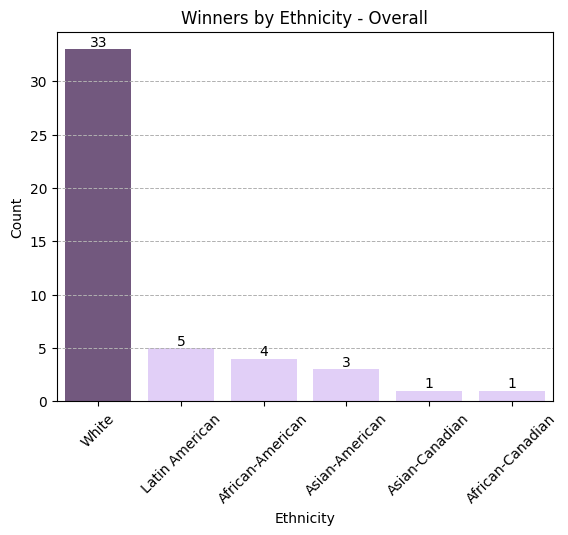

In [ ]:
winner_ethn_overall = '''
SELECT 
    Ethnicity, COUNT(Ethnicity) as Count
FROM 
    contestants
WHERE 
    Finish = 1
GROUP BY 
    Ethnicity
ORDER BY 
    Count DESC;
'''
sql(winner_ethn_overall)
max_count = sql(winner_ethn_overall)['Count'].max()

colors = ['#745284' if count == max_count else '#E0C9FD' for count in sql(winner_ethn_overall)['Count']]
plot = sns.barplot(x='Ethnicity',
                    y='Count',
                    data=sql(winner_ethn_overall),
                    palette=colors,
                    hue='Ethnicity',
                    legend=False,)
for bar in plot.patches:
    height = bar.get_height()
    plot.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.0f}',
        ha='center',
        va='bottom'
    )
plt.title('Winners by Ethnicity - Overall')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
plt.tick_params(axis='x', rotation=45)
plt.show()

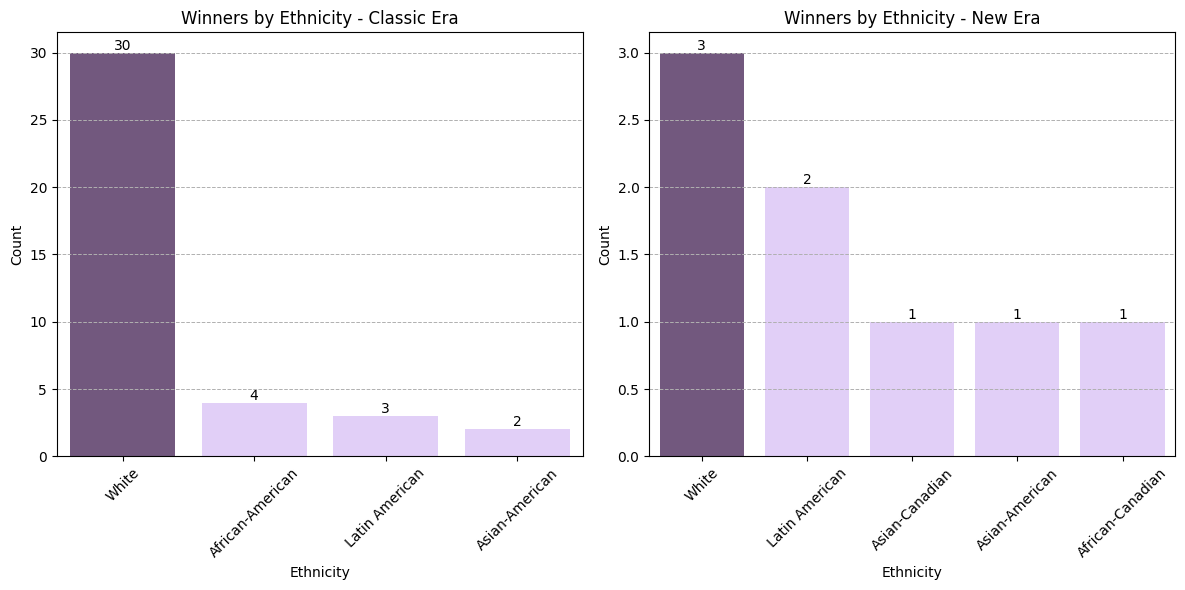

In [ ]:
# Are there any shared demographics of top players? (High Survivor Scores/Averages, (Most Idols played- not necessarily 'top' players), Season winners)
winner_ethn_classic = '''
SELECT 
    Ethnicity, COUNT(Ethnicity) as Count
FROM 
    contestants
WHERE 
    Finish = 1 AND Season <= 39
GROUP BY 
    Ethnicity
ORDER BY 
    Count DESC;
'''
sql(winner_ethn_classic)
max_count = sql(winner_ethn_classic)['Count'].max()

winner_ethn_new_era = '''
SELECT 
    Ethnicity, COUNT(Ethnicity) as Count
FROM 
    contestants
WHERE 
    Finish = 1 AND Season >= 40
GROUP BY 
    Ethnicity 
ORDER BY 
    Count DESC;
'''
sql(winner_ethn_new_era)
max_new_count = sql(winner_ethn_new_era)['Count'].max()

colors1 = ['#745284' if count == max_count else '#E0C9FD' for count in sql(winner_ethn_classic)['Count']]
colors2 = ['#745284' if count == max_new_count else '#E0C9FD' for count in sql(winner_ethn_new_era)['Count']]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot1 = sns.barplot(x='Ethnicity',
                    y='Count',
                    data=sql(winner_ethn_classic),
                    palette=colors1,
                    hue='Ethnicity',
                    legend=False,
                    ax=axes[0])
axes[0].set_title('Winners by Ethnicity - Classic Era')
for bar in plot1.patches:
    height = bar.get_height()
    plot1.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.0f}',
        ha='center',
        va='bottom'
    )
axes[0].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
axes[0].tick_params(axis='x', rotation=45)

plot2 = sns.barplot(x='Ethnicity',
                    y='Count',
                    data=sql(winner_ethn_new_era),
                    palette=colors2,
                    hue='Ethnicity',
                    legend=False,
                    ax=axes[1])
axes[1].set_title('Winners by Ethnicity - New Era')
for bar in plot2.patches:
    height = bar.get_height()
    plot2.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.0f}',
        ha='center',
        va='bottom'
    )
axes[1].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

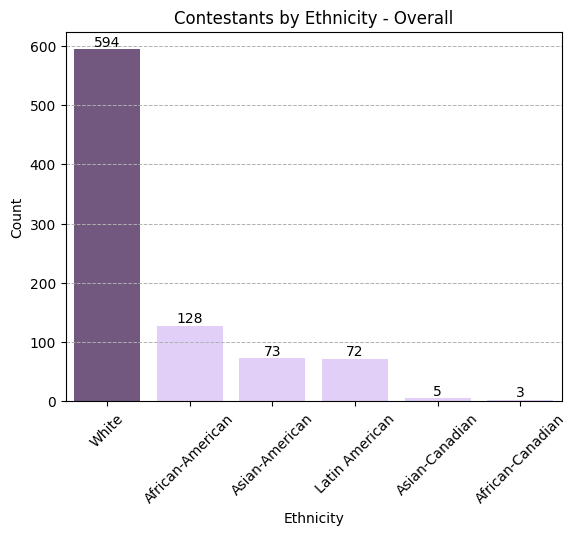

In [140]:
overall_ethnicity = '''
SELECT 
    Ethnicity, COUNT(Ethnicity) as Count
FROM 
    contestants
GROUP BY 
    Ethnicity
ORDER BY 
    Count DESC;
'''
sql(overall_ethnicity)
max_count = sql(overall_ethnicity)['Count'].max()

colors = ['#745284' if count == max_count else '#E0C9FD' for count in sql(overall_ethnicity)['Count']]
plot = sns.barplot(x='Ethnicity',
                    y='Count',
                    data=sql(overall_ethnicity),
                    palette=colors,
                    hue='Ethnicity',
                    legend=False,)
for bar in plot.patches:
    height = bar.get_height()
    plot.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.0f}',
        ha='center',
        va='bottom'
    )
plt.title('Contestants by Ethnicity - Overall')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
plt.tick_params(axis='x', rotation=45)
plt.show()

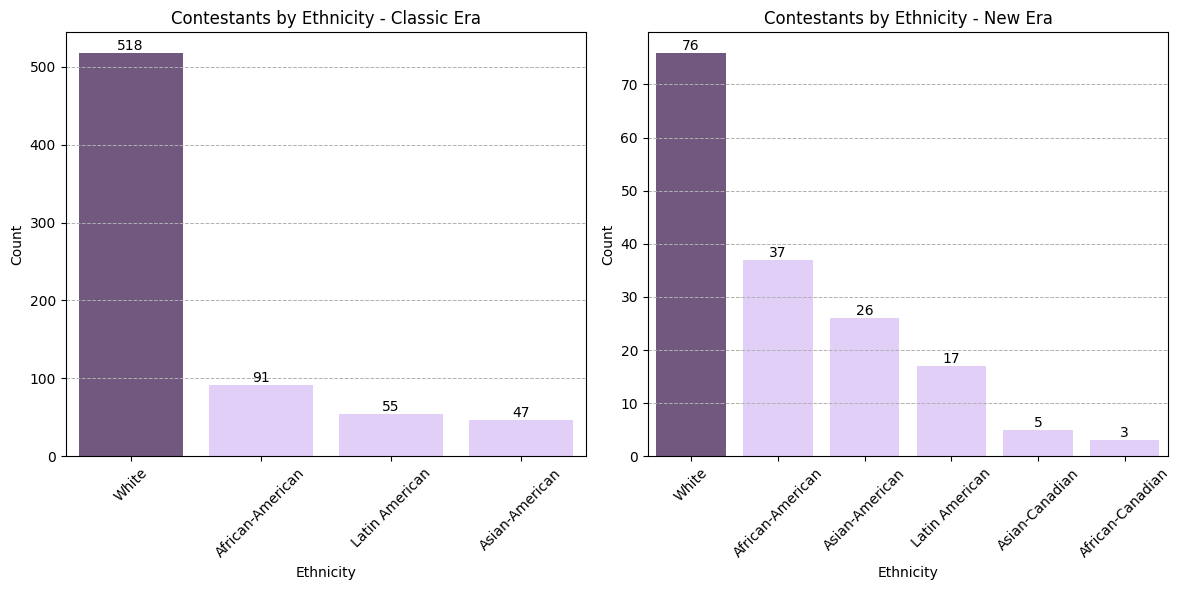

In [ ]:
classic_era_ethnicity = '''
SELECT 
    Ethnicity, COUNT(Ethnicity) as Count
FROM 
    contestants
WHERE 
    Season <= 39
GROUP BY 
    Ethnicity
ORDER BY 
    Count DESC;
'''
sql(classic_era_ethnicity)
max_count = sql(classic_era_ethnicity)['Count'].max()

new_era_ethnicity = '''
SELECT 
    Ethnicity, COUNT(Ethnicity) as Count
FROM 
    contestants
WHERE 
    Season >= 40
GROUP BY 
    Ethnicity
ORDER BY 
    Count DESC;
'''
sql(new_era_ethnicity)
max_new_count = sql(new_era_ethnicity)['Count'].max()

colors1 = ['#745284' if count == max_count else '#E0C9FD' for count in sql(classic_era_ethnicity)['Count']]
colors2 = ['#745284' if count == max_new_count else '#E0C9FD' for count in sql(new_era_ethnicity)['Count']] # set colors

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot1 = sns.barplot(x='Ethnicity', 
                   y='Count', 
                   data=sql(classic_era_ethnicity), 
                   palette=colors1, 
                   hue='Ethnicity', 
                   legend=False,
                   ax=axes[0])
axes[0].set_title('Contestants by Ethnicity - Classic Era')
for bar in plot1.patches:
    height = bar.get_height()
    plot1.text(
        bar.get_x() + bar.get_width() / 2,  
        height,                 
        f'{height:.0f}',
        ha='center',             
        va='bottom'                       
    )
axes[0].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
axes[0].tick_params(axis='x', rotation=45)


plot2 = sns.barplot(x='Ethnicity', 
                    y='Count', 
                    data=sql(new_era_ethnicity), 
                    palette=colors2, 
                    hue='Ethnicity', 
                    legend=False, 
                    ax=axes[1])
for bar in plot2.patches:
    height = bar.get_height()
    plot2.text(
        bar.get_x() + bar.get_width() / 2,  
        height,                 
        f'{height:.0f}',
        ha='center',             
        va='bottom'                       
    )
axes[1].set_title('Contestants by Ethnicity - New Era')
axes[1].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

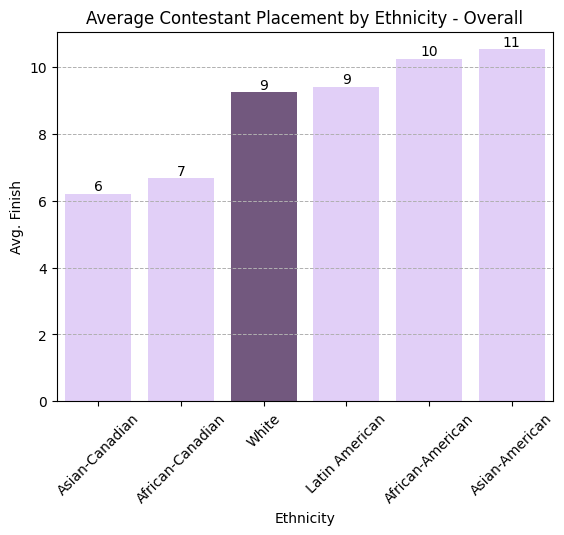

In [141]:
avg_placement_overall = '''
SELECT 
    Ethnicity, AVG(Finish) as 'Avg. Finish'
FROM 
    contestants
GROUP BY 
    Ethnicity
ORDER BY 
    AVG(Finish) ASC;
'''
sql(avg_placement_overall)

colors = ['#745284' if ethnicity == 'White' else '#E0C9FD' for ethnicity in sql(avg_placement_overall)['Ethnicity']]
plot = sns.barplot(x='Ethnicity',
                    y='Avg. Finish',
                    data=sql(avg_placement_overall),
                    palette=colors,
                    hue='Ethnicity',
                    legend=False,)
for bar in plot.patches:
    height = bar.get_height()
    plot.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.0f}',
        ha='center',
        va='bottom'
    )
plt.title('Average Contestant Placement by Ethnicity - Overall')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
plt.tick_params(axis='x', rotation=45)
plt.show()

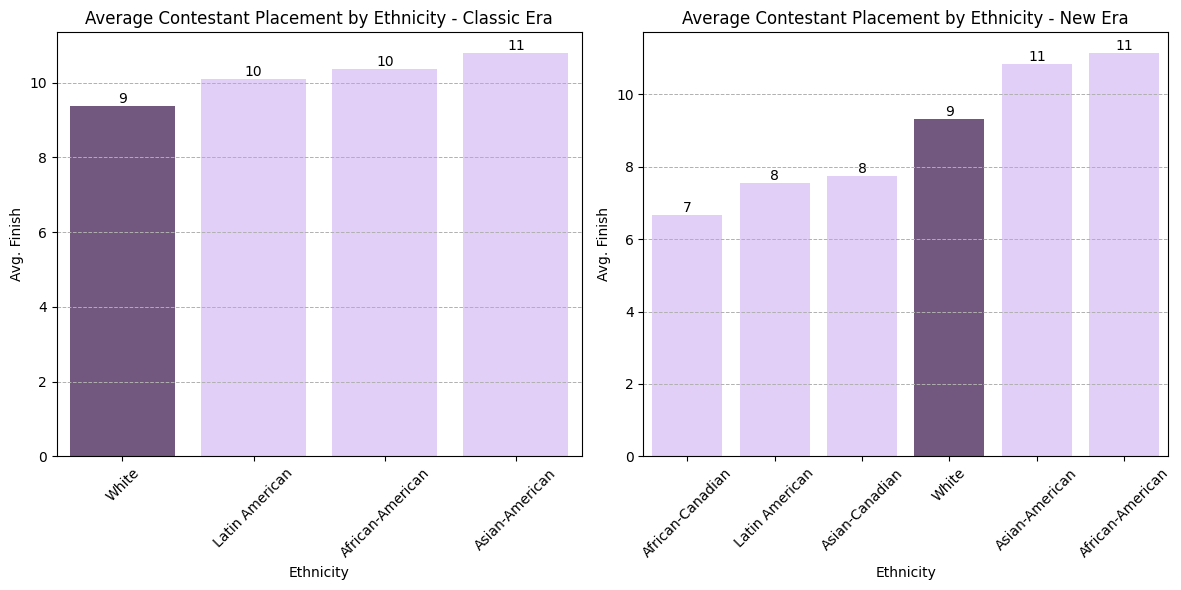

In [ ]:
# Avg Contestant Placements (Ethnicity) bar charts
avg_placement_classic = '''
SELECT 
    Ethnicity, AVG(Finish) as 'Avg. Finish'
FROM 
    contestants
WHERE 
    Season <= 39
GROUP BY 
    Ethnicity
ORDER BY 
    AVG(Finish) ASC;
'''
sql(avg_placement_classic)


avg_placement_new = '''
SELECT 
    Ethnicity, AVG(Finish) as 'Avg. Finish'
FROM 
    contestants
WHERE 
    Season >= 40 AND Finish <> 0
GROUP BY 
    Ethnicity
ORDER BY 
    AVG(Finish) ASC;
'''
sql(avg_placement_new)

colors1 = ['#745284' if ethnicity == 'White' else '#E0C9FD' for ethnicity in sql(avg_placement_classic)['Ethnicity']]
colors2 = ['#745284' if ethnicity == 'White' else '#E0C9FD' for ethnicity in sql(avg_placement_new)['Ethnicity']]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot1 = sns.barplot(x='Ethnicity', 
                   y='Avg. Finish', 
                   data=sql(avg_placement_classic), 
                   palette=colors1, 
                   hue='Ethnicity', 
                   legend=False,
                   ax=axes[0])
axes[0].set_title('Average Contestant Placement by Ethnicity - Classic Era')
for bar in plot1.patches:
    height = bar.get_height()
    plot1.text(
        bar.get_x() + bar.get_width() / 2,  
        height,                 
        f'{height:.0f}',
        ha='center',             
        va='bottom'                       
    )
axes[0].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
axes[0].tick_params(axis='x', rotation=45)


plot2 = sns.barplot(x='Ethnicity', 
                    y='Avg. Finish', 
                    data=sql(avg_placement_new), 
                    palette=colors2, 
                    hue='Ethnicity', 
                    legend=False, 
                    ax=axes[1])
for bar in plot2.patches:
    height = bar.get_height()
    plot2.text(
        bar.get_x() + bar.get_width() / 2,  
        height,                 
        f'{height:.0f}',
        ha='center',             
        va='bottom'                       
    )
axes[1].set_title('Average Contestant Placement by Ethnicity - New Era')
axes[1].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

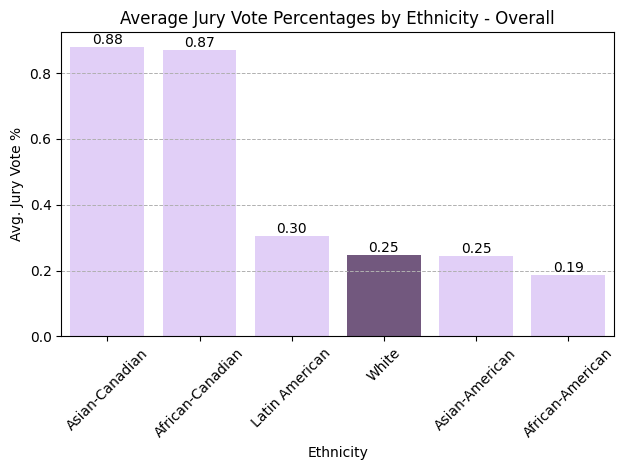

In [144]:
jury_votes_overall = '''
SELECT 
    AVG(s.'Jury Votes %') as 'Avg. Jury Vote %', c.Ethnicity
FROM 
    contestants as c
LEFT JOIN 
    stats as s ON c.Name = s.Contestant
WHERE 
    c.Finish = 1 OR c.Finish = 2
GROUP BY 
    Ethnicity
ORDER BY 
    AVG(s.'Jury Votes %') DESC;
'''
sql(jury_votes_overall)

colors = ['#745284' if ethnicity == 'White' else '#E0C9FD' for ethnicity in sql(jury_votes_overall)['Ethnicity']]


plot = sns.barplot(x='Ethnicity', 
                   y='Avg. Jury Vote %', 
                   data=sql(jury_votes_overall), 
                   palette=colors, 
                   hue='Ethnicity', 
                   legend=False,)

for bar in plot.patches:
    height = bar.get_height()
    plot.text(
        bar.get_x() + bar.get_width() / 2,  
        height,                 
        f'{height:.2f}',
        ha='center',             
        va='bottom'                       
    )
plt.title('Average Jury Vote Percentages by Ethnicity - Overall')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

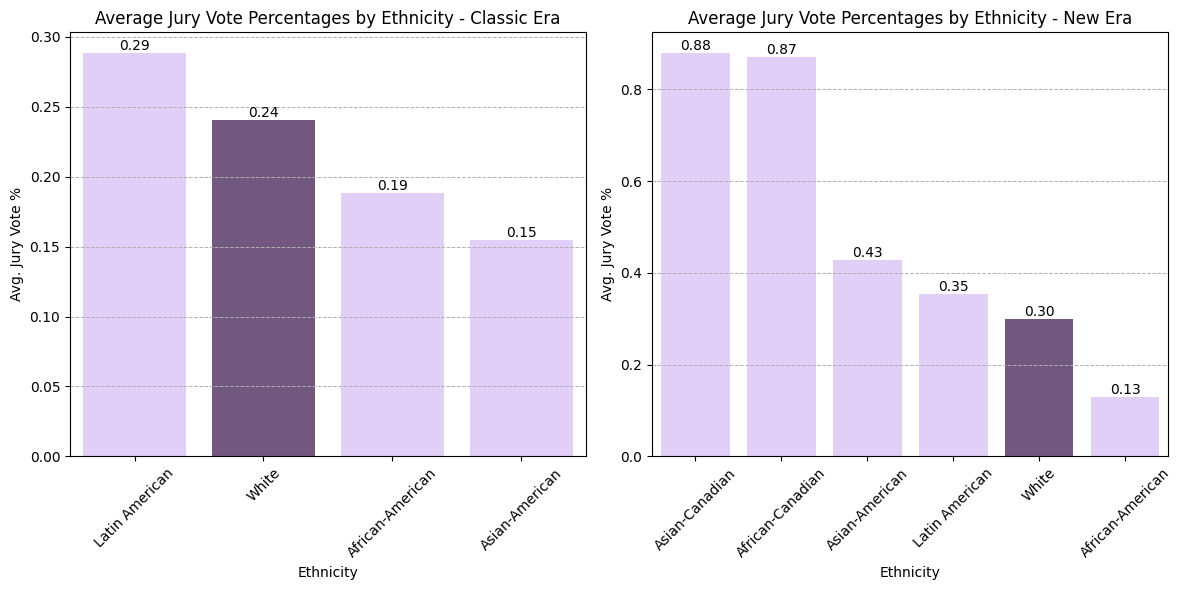

In [ ]:
# Avg Jury Vote % (Ethnicity) bar charts
jury_votes_classic = '''
SELECT 
    AVG(s.'Jury Votes %') as 'Avg. Jury Vote %', c.Ethnicity
FROM 
    contestants as c
LEFT JOIN 
    stats as s ON c.Name = s.Contestant
WHERE 
    c.Season <= 39 AND (c.Finish = 1 OR c.Finish = 2)
GROUP BY 
    Ethnicity
ORDER BY 
    AVG(s.'Jury Votes %') DESC;
'''
sql(jury_votes_classic)


jury_votes_new = '''
SELECT 
    AVG(s.'Jury Votes %') as 'Avg. Jury Vote %', c.Ethnicity
FROM 
    contestants as c
LEFT JOIN 
    stats as s ON c.Name = s.Contestant
WHERE 
    c.Season >= 40 AND (c.Finish = 1 OR c.Finish = 2)
GROUP BY 
    Ethnicity
ORDER BY 
    AVG(s.'Jury Votes %') DESC;
'''
sql(jury_votes_new)

colors1 = ['#745284' if ethnicity == 'White' else '#E0C9FD' for ethnicity in sql(jury_votes_classic)['Ethnicity']]
colors2 = ['#745284' if ethnicity == 'White' else '#E0C9FD' for ethnicity in sql(jury_votes_new)['Ethnicity']]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot1 = sns.barplot(x='Ethnicity', 
                   y='Avg. Jury Vote %', 
                   data=sql(jury_votes_classic), 
                   palette=colors1, 
                   hue='Ethnicity', 
                   legend=False,
                   ax=axes[0])
axes[0].set_title('Average Jury Vote Percentages by Ethnicity - Classic Era')
for bar in plot1.patches:
    height = bar.get_height()
    plot1.text(
        bar.get_x() + bar.get_width() / 2,  
        height,                 
        f'{height:.2f}',
        ha='center',             
        va='bottom'                       
    )
axes[0].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
axes[0].tick_params(axis='x', rotation=45)


plot2 = sns.barplot(x='Ethnicity', 
                    y='Avg. Jury Vote %', 
                    data=sql(jury_votes_new), 
                    palette=colors2, 
                    hue='Ethnicity', 
                    legend=False, 
                    ax=axes[1])
for bar in plot2.patches:
    height = bar.get_height()
    plot2.text(
        bar.get_x() + bar.get_width() / 2,  
        height,                 
        f'{height:.2f}',
        ha='center',             
        va='bottom'                       
    )
axes[1].set_title('Average Jury Vote Percentages by Ethnicity - New Era')
axes[1].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# What are the average placements of various demographics? (Age ranges, gender, ethnicity, possibly profession and hometown)
gender_sql = '''
SELECT 
    Gender,COUNT(Gender) as Count
FROM 
    contestants
GROUP BY 
    Gender
ORDER BY 
    Count;
'''
sql(gender_sql)


,Gender,Count
0,N,2
1,F,434
2,M,439


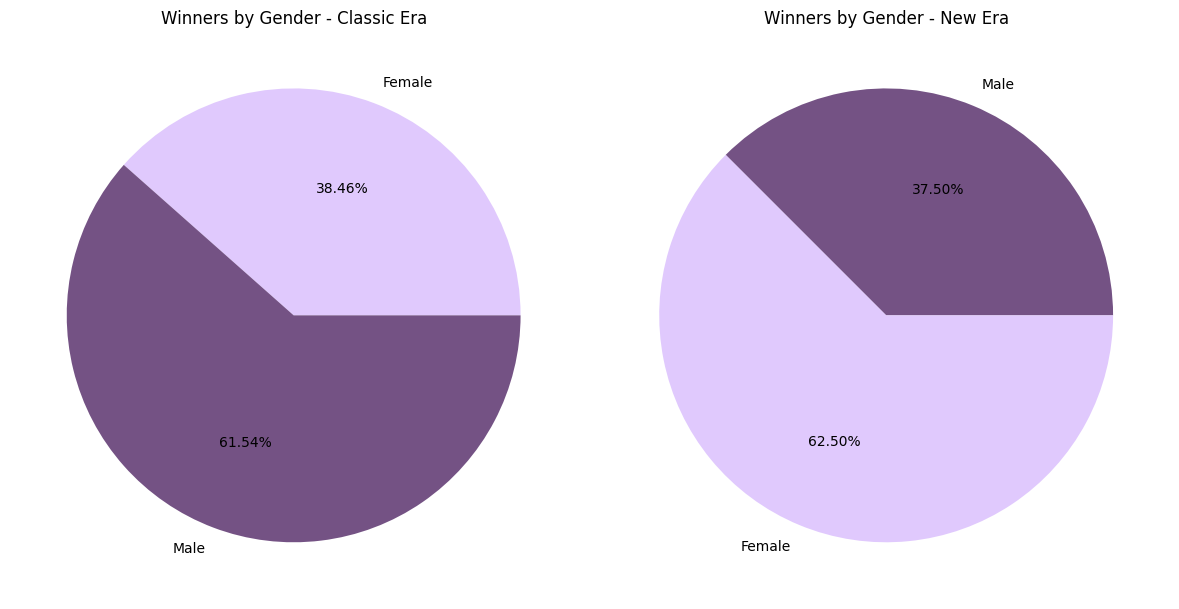

In [ ]:
# Gender pie charts
winner_genders_classic = '''
SELECT 
    (CASE Gender
        WHEN 'F' THEN 'Female'
        WHEN 'M' THEN 'Male'
        ELSE 'Non-binary'
    END) as Gender, COUNT(Gender) as Count
FROM 
    contestants 
WHERE 
    Finish = 1 AND Season <= 39
GROUP BY 
    Gender
ORDER BY 
    Count;
'''
sql(winner_genders_classic)
max_count = sql(winner_genders_classic)['Count'].max()

winner_genders_new = '''
SELECT 
    (CASE Gender
        WHEN 'F' THEN 'Female'
        WHEN 'M' THEN 'Male'
        ELSE 'Non-binary'
    END) as Gender, COUNT(Gender) as Count
FROM 
    contestants 
WHERE 
    Finish = 1 AND Season >= 40
GROUP BY 
    Gender
ORDER BY 
    Count;
'''
sql(winner_genders_new)
max_count_new = sql(winner_genders_new)['Count'].max()

colors1 = ['#745284' if gender == 'Male' else '#E0C9FD' for gender in sql(winner_genders_classic)['Gender']]
colors2 = ['#745284' if gender == 'Male' else '#E0C9FD' for gender in sql(winner_genders_new)['Gender']]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(sql(winner_genders_classic)['Count'], colors = colors1, labels=sql(winner_genders_classic)['Gender'], autopct='%.2f%%')
axes[0].set_title('Winners by Gender - Classic Era')

axes[1].pie(sql(winner_genders_new)['Count'], colors = colors2, labels=sql(winner_genders_new)['Gender'], autopct='%.2f%%')
axes[1].set_title('Winners by Gender - New Era')

plt.tight_layout()
plt.show()

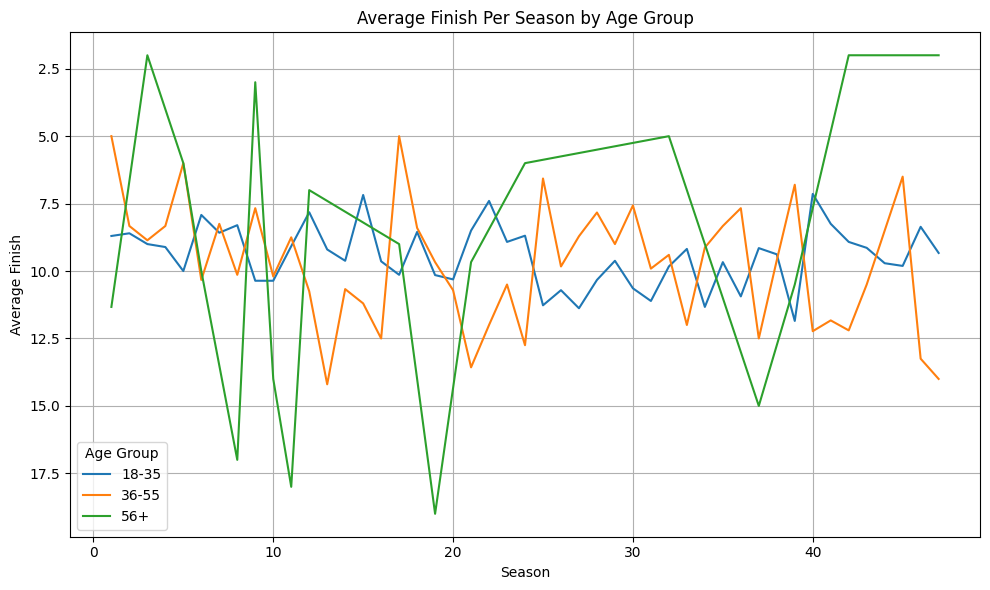

In [104]:
# Age ranges can probably be defined using CASE - line chart avg contestant placement by age group per season
avg_placement_age = '''
SELECT 
    (CASE 
        WHEN Age BETWEEN 18 AND 35 THEN '18-35'
        WHEN Age BETWEEN 36 AND 55 THEN '36-55'
        ELSE '56+'
    END) as 'Age Group', Season, ROUND(AVG(Finish), 2) as 'Avg. Finish'
FROM 
    contestants
WHERE 
    Finish <> 0 AND Season <> 48 
GROUP BY 
    Season, (CASE 
            WHEN Age BETWEEN 18 AND 35 THEN '18-35'
            WHEN Age BETWEEN 36 AND 55 THEN '36-55'
            ELSE '56+'
            END)
ORDER BY 
    Season, 'Age Group';
'''

age_placement = sql(avg_placement_age)  
age_placement = age_placement.pivot(index='Season', columns='Age Group', values='Avg. Finish')
age_placement = age_placement.interpolate(method='linear')

plt.figure(figsize=(10, 6))
for age_group in age_placement.columns:
    plt.plot(age_placement.index, age_placement[age_group], label=age_group)
plt.title('Average Finish Per Season by Age Group')
plt.xlabel('Season')
plt.ylabel('Average Finish')
plt.legend(title='Age Group')

plt.grid(True)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


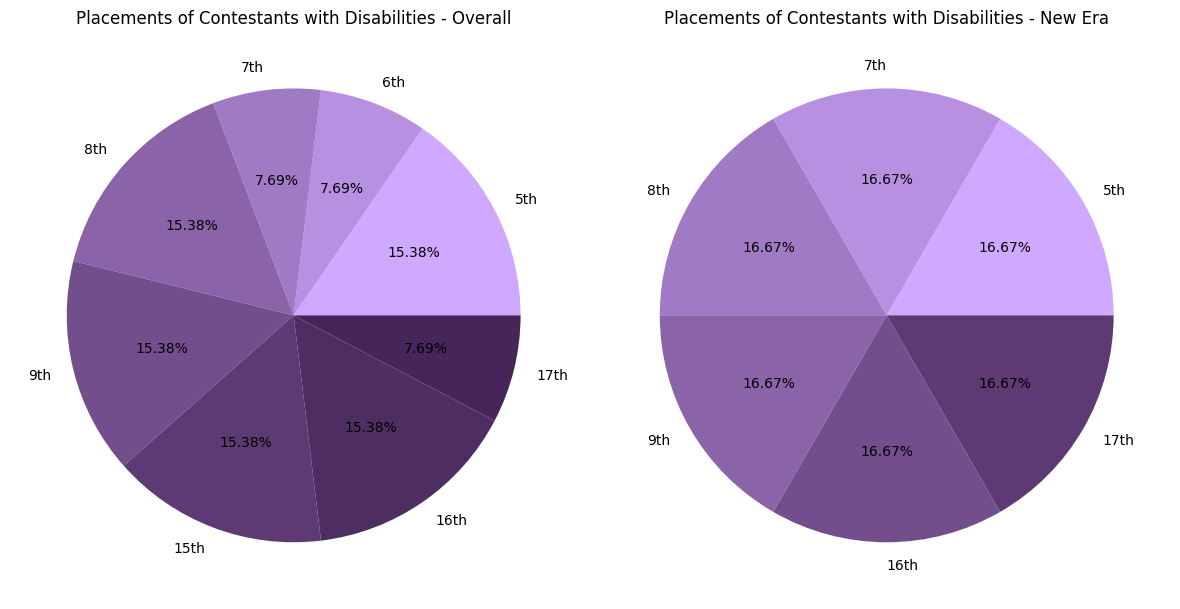

In [137]:
# disbaility contestant placement pie charts
disability_placement = '''
SELECT 
    (CASE 
        WHEN c.Finish = 1 THEN '1st'
        WHEN c.Finish = 2 THEN '2nd'
        WHEN c.Finish = 3 THEN '3rd'
        ELSE CAST(c.Finish AS TEXT) || 'th' END) as Finish, COUNT(s.Contestant) as Count 
FROM 
    contestants as c
LEFT JOIN 
    stats as s ON c.Name = s.Contestant
WHERE 
    c.'Has Disability' = True AND Finish <> 0
GROUP BY 
    c.Finish
ORDER BY    
    c.Finish, Count;
''' 
sql(disability_placement)

disability_placement_new = '''
SELECT  
    (CASE 
        WHEN c.Finish = 1 THEN '1st'
        WHEN c.Finish = 2 THEN '2nd'
        WHEN c.Finish = 3 THEN '3rd'
        ELSE CAST(c.Finish AS TEXT) || 'th' END) as Finish, COUNT(s.Contestant) as Count 
FROM 
    contestants as c
LEFT JOIN 
    stats as s ON c.Name = s.Contestant
WHERE 
    c.'Has Disability' = True AND c.Finish <> 0 AND c.Season >= 40
GROUP BY 
    c.Finish
ORDER BY 
    c.Finish, Count;
''' 
sql(disability_placement_new)

colors = ['#CFA8FF', '#B890E1', '#A07AC4', '#8A63A8', '#734E8D', '#5D3A73', '#4E2D62', '#46265A']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(sql(disability_placement)['Count'], colors = colors, labels=sql(disability_placement)['Finish'], autopct='%.2f%%')
axes[0].set_title('Placements of Contestants with Disabilities - Overall')

axes[1].pie(sql(disability_placement_new)['Count'], colors = colors, labels=sql(disability_placement_new)['Finish'], autopct='%.2f%%')
axes[1].set_title('Placements of Contestants with Disabilities - New Era')

plt.tight_layout()
plt.show()

In [ ]:
# What does the geographical distribution of winners look like? GEOPANDAS MAP - overall 
location = '''
SELECT 
    State, COUNT(State) as Count
FROM 
    contestants
WHERE 
    Finish = 1
GROUP BY 
    State
ORDER BY 
    Count DESC;
'''
sql(location)

,State,Count
0,CA,8
1,NY,4
2,NJ,4
3,PA,3
4,UT,2
5,TX,2
6,ON,2
7,NC,2
8,ID,2
9,IA,2


### Findings:

Draft : This project could be worked on further by checking the  percentage of demographics of players against census data

IT could also

### Conclusions: